# __Flood Risk Modelling on Road Network__
##### Yingzhe Lei Oct 2024

### 1. Data Collection and Cleanning

C:\Users\3057411\AppData\Local\Temp\ipykernel_7712\4168793013.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  roadnetwork.to_file('london_road.shp')
C:\Users\3057411\AppData\Local\Temp\ipykernel_7712\4168793013.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  road_study_area.to_file('case_road.shp')


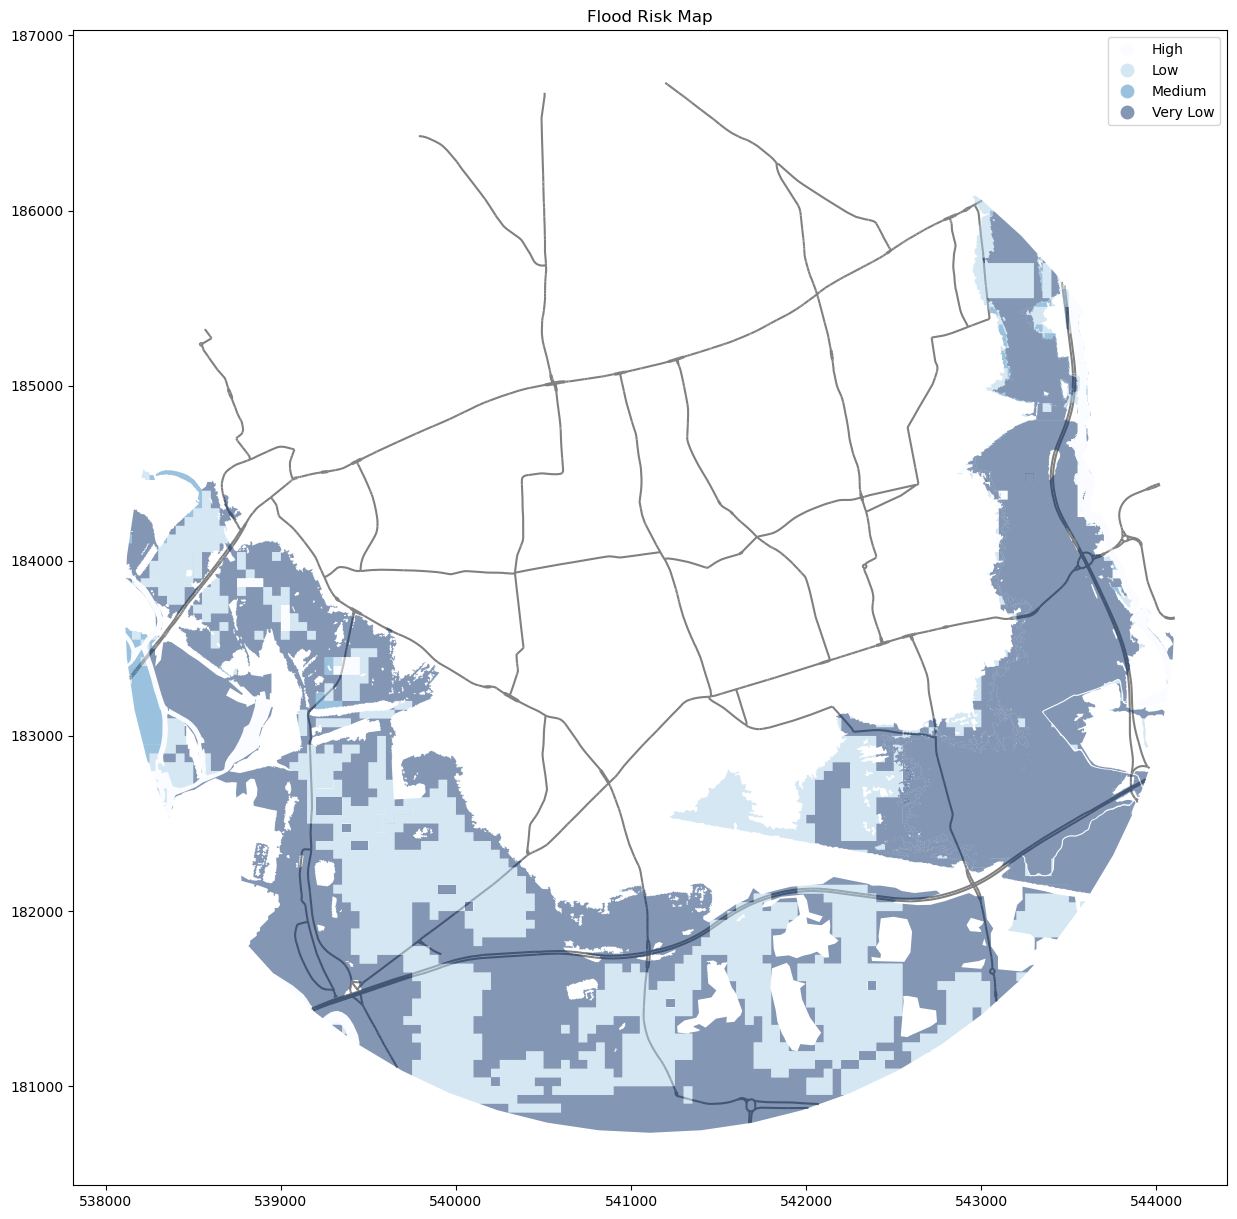

In [5]:
import geopandas as gpd
import osmnx as ox
import functions as f

#Flood data:collect, clip and save
#Flooding shp data downloaded from: https://www.data.gov.uk/dataset/bad20199-6d39-4aad-8564-26a46778fd94/risk-of-flooding-from-rivers-and-sea
#(Use boundary polygon of London to clip when downloading)
#Clip centre:Upton Park rail station, coordinates:[51.5348841,0.0330656]
#Clip area radius: 3000m
flood_risk_whole=gpd.read_file("London_Risk_of_Flooding_from_Rivers_and_Sea.shp")
flood_risk_whole.to_file('london_flood.shp')
flood_study_area=f.clip_study_area(flood_risk_whole,[51.5348841,0.0330656],3000)
flood_study_area.to_file('case_flood.shp')

#Road network:collect,clip and save
place="London, United Kingdom"
tags={"highway":["motorway","trunk","primary","secondary"]}
roadnetwork=ox.features_from_place(place,tags)
roadnetwork=roadnetwork.to_crs("EPSG:27700")
roadnetwork=gpd.GeoDataFrame({},geometry=roadnetwork.geometry,crs="EPSG:27700")
roadnetwork.to_file('london_road.shp')
road_study_area=f.clip_study_area(roadnetwork,[51.5348841,0.0330656],3000)
road_study_area.to_file('case_road.shp')

#Visualization
ax=road_study_area.plot(
    alpha=1,
    color='grey',
    figsize=(15,15),
    zorder=1,
)
flood_study_area.plot(
    ax=ax,
    column="prob_4band",
    cmap='Blues',
    categorical=True,
    legend=True,
    alpha=0.5,
    figsize=(15,15),
    zorder=2,
)
_ =ax.set_title('Flood Risk Map')

### 2. Data Processing

c:\Users\3057411\AppData\Local\anaconda3\envs\python11\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\3057411\AppData\Local\Temp\ipykernel_7712\3519725406.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hexgrid.to_file("gridpoint.shp")


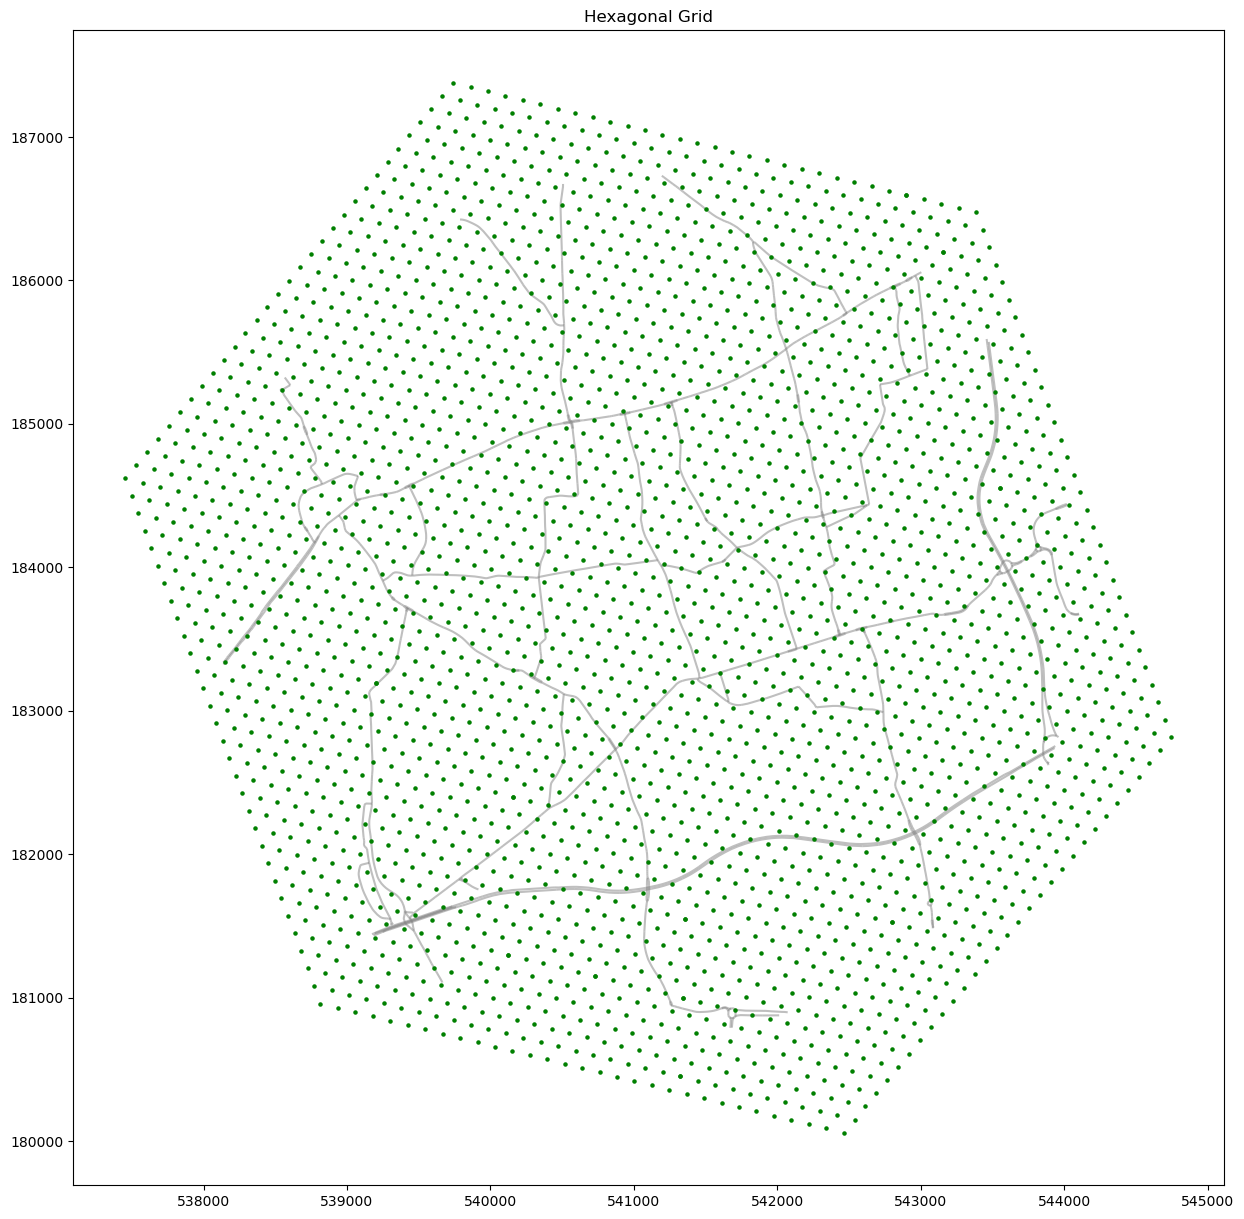

In [6]:
import geopandas as gpd
import functions as f
from importlib import reload

reload(f)

#Split road network into segments
#Segment resolution = 30
road=gpd.read_file('case_road.shp')
segmented_road=f.road_split(road,30)
segmented_road.to_file("segmented_road.shp")
s_roadpoint=[]
for segment in segmented_road.geometry:
    s_roadpoint.append(segment.interpolate(0.5,normalized=True))
s_roadpoint=gpd.GeoDataFrame({"pointid":range(0,len(s_roadpoint))},geometry=s_roadpoint,crs="EPSG:27700")
s_roadpoint.to_file("s_roadpoint.shp")

#Create hexagonal grid and assign flood risk to grid points
#Grid resolution = 10; Grid size =30
flood=gpd.read_file("london_flood.shp")
hexgrid=f.create_grid([51.5348841,0.0330656],10,30)
valuegrid=gpd.sjoin(hexgrid,flood,how='inner',op='intersects')  
hexgrid=hexgrid.overlay(valuegrid,how='union')
hexgrid=hexgrid.drop(columns=['gridid_2'])
hexgrid.to_file("gridpoint.shp") 

#Visualization
ax=road.plot(
    alpha=0.5,
    color='grey',
    figsize=(15,15),
    legend=True,
    zorder=1,
)
hexgrid.plot(
    ax=ax,
    color='green',
    markersize=5,
    legend=True,
    alpha=1,
    figsize=(15,15),
    zorder=2,
)
_ =ax.set_title('Hexagonal Grid')

### 3. Network Analysis

C:\Users\3057411\AppData\Local\Temp\ipykernel_7712\1580760446.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  s_roadpoint_betweenness_2.to_file("s_roadpoint22.shp")


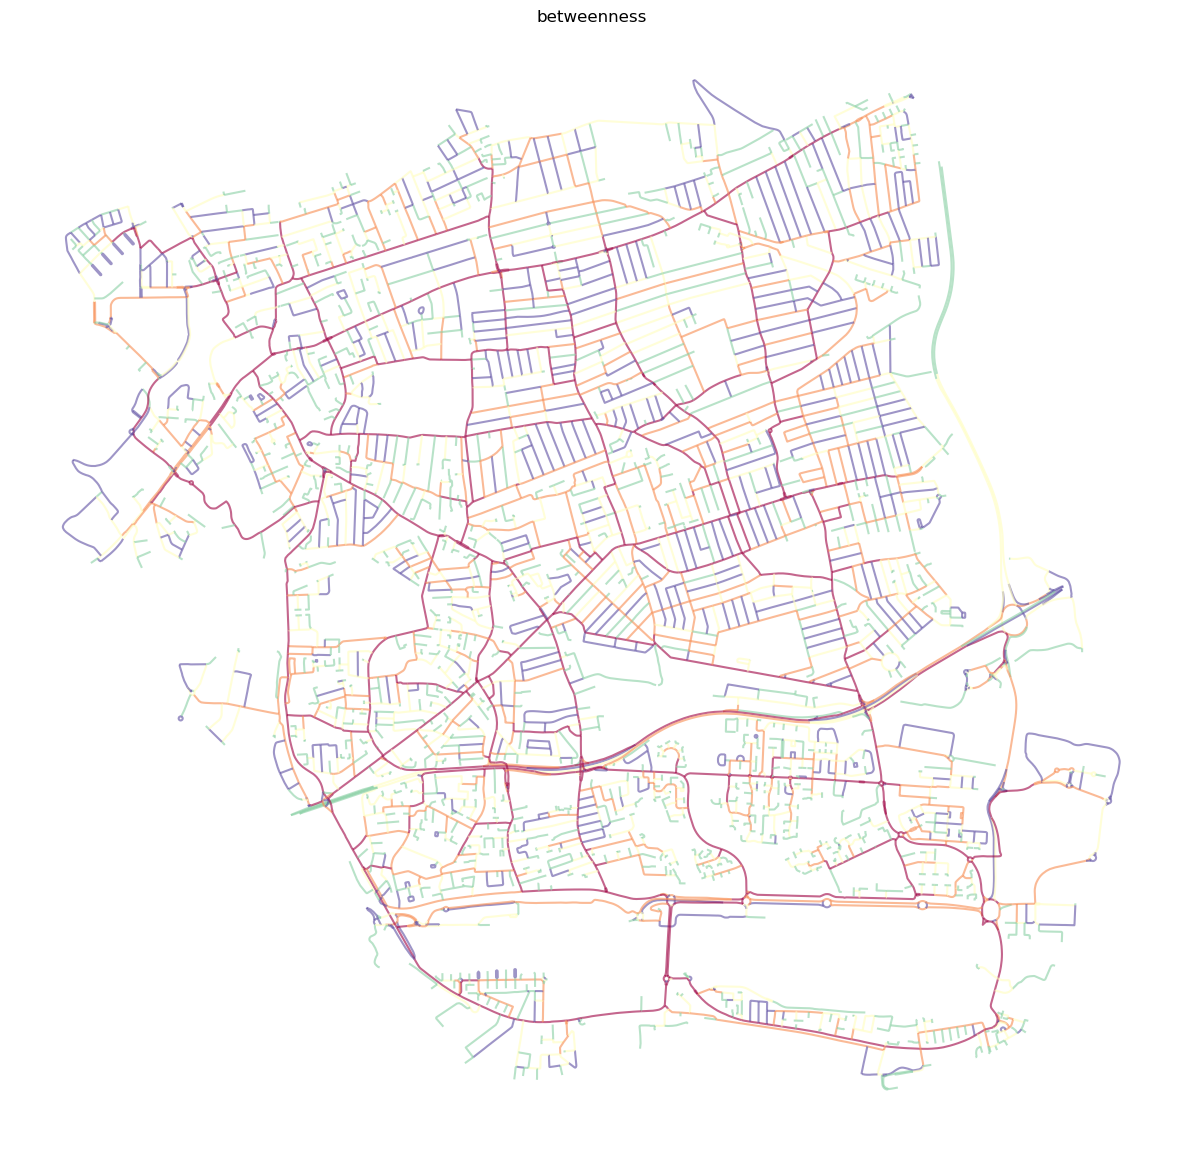

In [7]:
import osmnx as ox
import momepy
import geopandas as gpd

#Network Analysis
#Build graph out of road network
G=ox.graph_from_place("Newham, London, United Kingdom",network_type="drive")
G=ox.projection.project_graph(G)
edges=ox.graph_to_gdfs(
    ox.convert.to_undirected(G),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)
G2=momepy.gdf_to_nx(edges,approach="primal")

#Calculating betweenness of edges and save results
G2=momepy.betweenness_centrality(
    G2, name="between",mode="edges",weight="mm_len"
)
result_gdf=momepy.nx_to_gdf(G2,points=False)
result_gdf=result_gdf.to_crs("EPSG:27700")
result_gdf= result_gdf.drop(columns=['from','to'])
s_roadpoint=gpd.read_file("s_roadpoint.shp")
s_roadpoint_betweenness_2=s_roadpoint.sjoin_nearest(result_gdf)
s_roadpoint_betweenness_2=s_roadpoint_betweenness_2.drop(columns=['osmid','lanes','name','maxspeed','reversed','ref'])
s_roadpoint_betweenness_2.to_file("s_roadpoint22.shp") 

#Visualization 
ax=result_gdf.plot(
    column="between",
    cmap="Spectral_r",
    scheme="quantiles",
    alpha=0.6,
    figsize=(15,15),
)
ax.set_axis_off()
_ =ax.set_title("betweenness")


### 4. KNN Classification

In [ ]:
import geopandas as gpd
import functions as f
from importlib import reload

reload(f)

#KNN classification and save results
#k=3
s_roadpoint=gpd.read_file("s_roadpoint22.shp")
gridpoint=gpd.read_file("gridpoint.shp")
s_roadpoint_risk=f.knearest(s_roadpoint,gridpoint,3,150)
s_roadpoint_risk.to_file("s_roadpoint3.shp")

### 5. Calculating Flood Risk Metric

<Axes: title={'center': 'Risk Score'}>

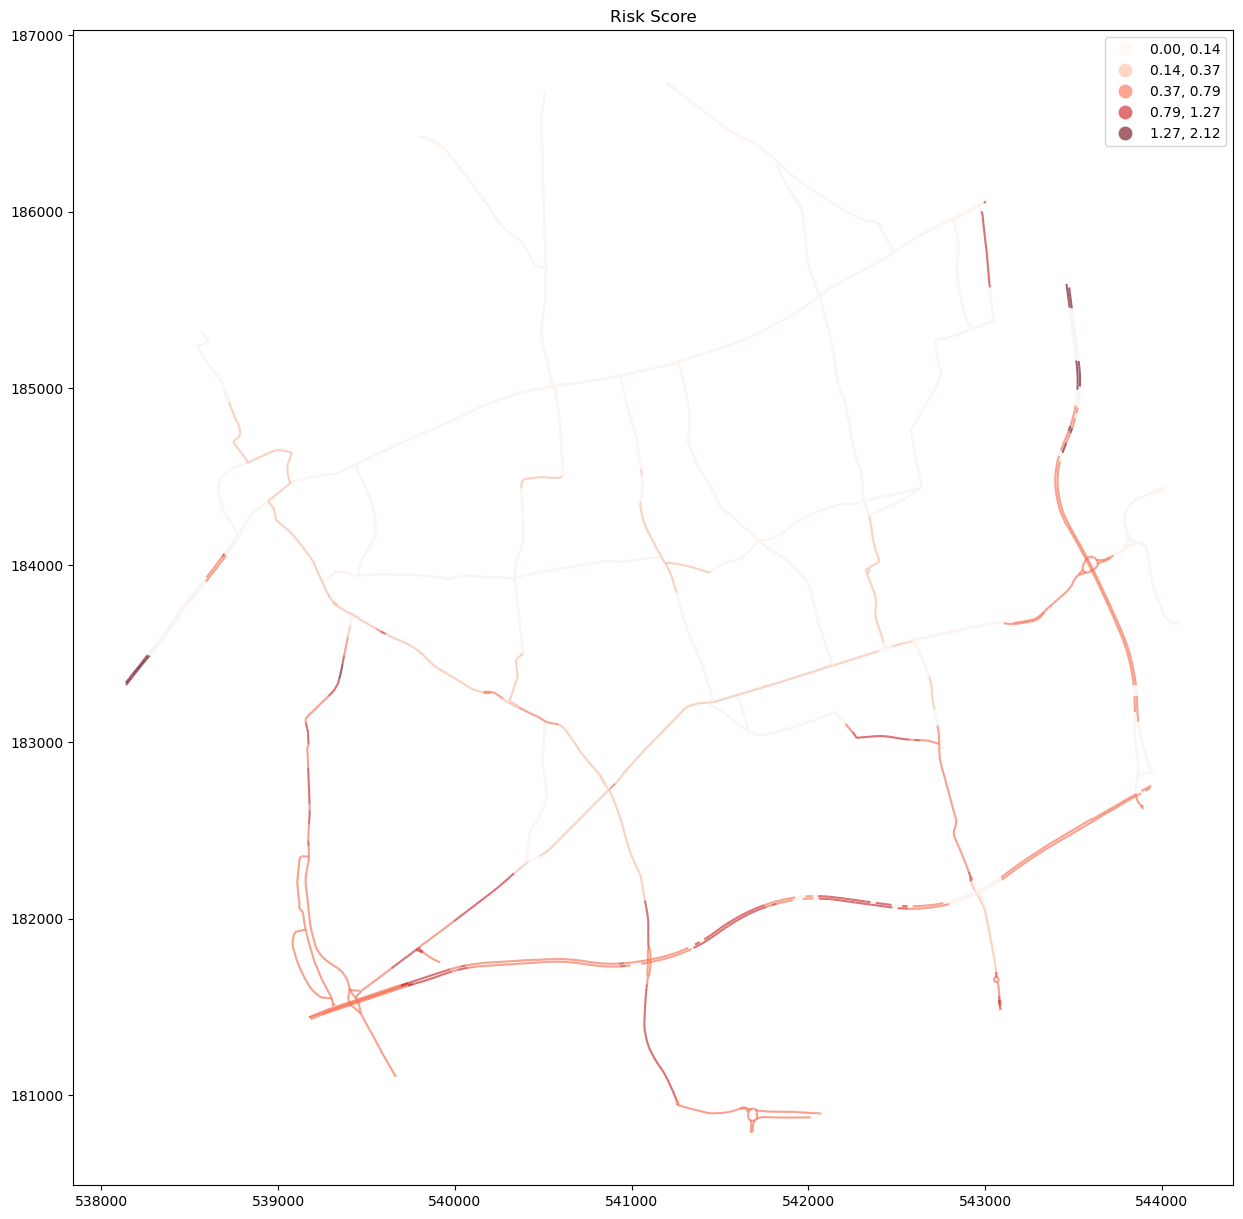

In [73]:
import geopandas as gpd
import functions as f
from importlib import reload

reload(f)

#Calculating risk score and assign values to segmented road network
s_roadpoint=gpd.read_file('s_roadpoint3.shp')
s_road=gpd.read_file('segmented_road.shp')
s_roadpoint["risk_value"]=[f.level_to_value(risk) for risk in s_roadpoint["risk"]]
s_roadpoint["n_between"]=[(x-s_roadpoint['between'].min())/(s_roadpoint['between'].max()-s_roadpoint['between'].min()) for x in s_roadpoint['between']]
s_roadpoint['n_risk']=[(x-s_roadpoint['risk_value'].min())/(s_roadpoint['risk_value'].max()-s_roadpoint['between'].min()) for x in s_roadpoint['risk_value']]
s_roadpoint["riskscore"]=s_roadpoint.apply(lambda row: (row.risk_value*0.5+row.n_between*0.5),axis=1)
s_road_with_s=s_road.sjoin_nearest(s_roadpoint,how='inner')

#Visualization
ax=s_road_with_s.plot(
    column="riskscore",
    cmap="Reds",
    scheme="NaturalBreaks",
    alpha=0.6,
    figsize=(15,15),
    legend=True,
    zorder=2
)
_ =ax.set_title('Risk Score')
s_road.plot(ax=ax,color='whitesmoke',zorder=1)
